# Load packages

In [1]:
from pathlib import Path
project_root = Path("/home/yangk/intership_2025_COSYS")

In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import json
import numpy as np

In [3]:
import sys

sys.path.append(str(project_root / "resource/DexiNed"))
sys.path.append(str(project_root / "src"))

from model import DexiNed
from dataset import BIPEDv2, transforms

# Prepare

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 50
batch_size = 8
learning_rate = 1e-4
biped_dataset = BIPEDv2(
    project_root / "data/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/",
    project_root / "data/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/"
)
# test set
test_dataset = BIPEDv2(
    project_root / "data/BIPEDv2/BIPED/edges/imgs/test/rgbr/",
    project_root / "data/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/"
)

model = DexiNed()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=8)
val_loader = DataLoader(test_dataset, batch_size=8)

print(device)

cuda


# Train or load

{'description': 'add NMS, Canny filter for Gx and Gy', 'num_epoch': 100, 'batch_size': 8, 'criterion': 'MSELoss', 'learning_rate': 0.0001}


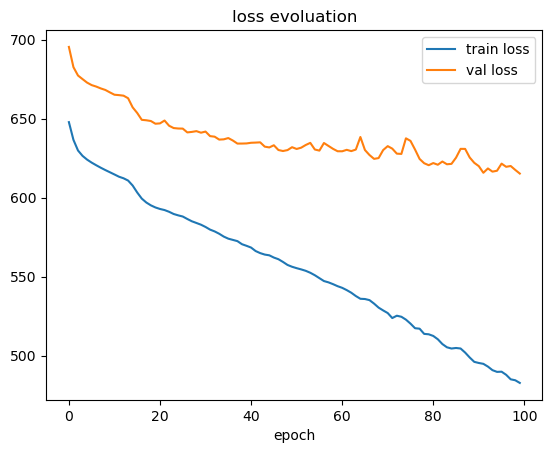

In [22]:
import matplotlib.pyplot as plt

prefix = project_root / "data/checkpoints/torch_point08"
model_path = prefix / "model.pth"
log_path = prefix / "log.json"

model.load_state_dict(torch.load(str(model_path), weights_only=True))
# # load log
with open(str(log_path), 'r') as f:
    logging = json.load(f)
print(logging['metadata'])
# # print the loss
# for e, (train_loss, val_loss) in enumerate(zip(logging['train_loss'], logging['val_loss'])):
#     print("-".join(["-"]*30))
#     print(f"In epoch {e}, the average  training  loss is {train_loss}")
#     print(f"In epoch {e}, the average validation loss is {val_loss}")
# Loss
plt.plot(logging['train_loss'], label="train loss")
plt.plot(logging['val_loss'], label="val loss")
plt.xlabel("epoch")
plt.title("loss evoluation")
plt.legend()
plt.show()

# Result

In [23]:
from PIL import Image
# take one example
item= biped_dataset.__getitem__(6)
img, x, y = Image.open(item['image_path']).convert('RGB'), item['image_tensor'], item['visibility_map']
# x = biped_dataset.transform(img)
# inference
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

In [24]:
# NMS
from nms import get_gradient_canny, nms_fully_vectorized

gx, gy = get_gradient_canny(x.mean(dim=0))
edge_map = nms_fully_vectorized(yhat, gx, gy)

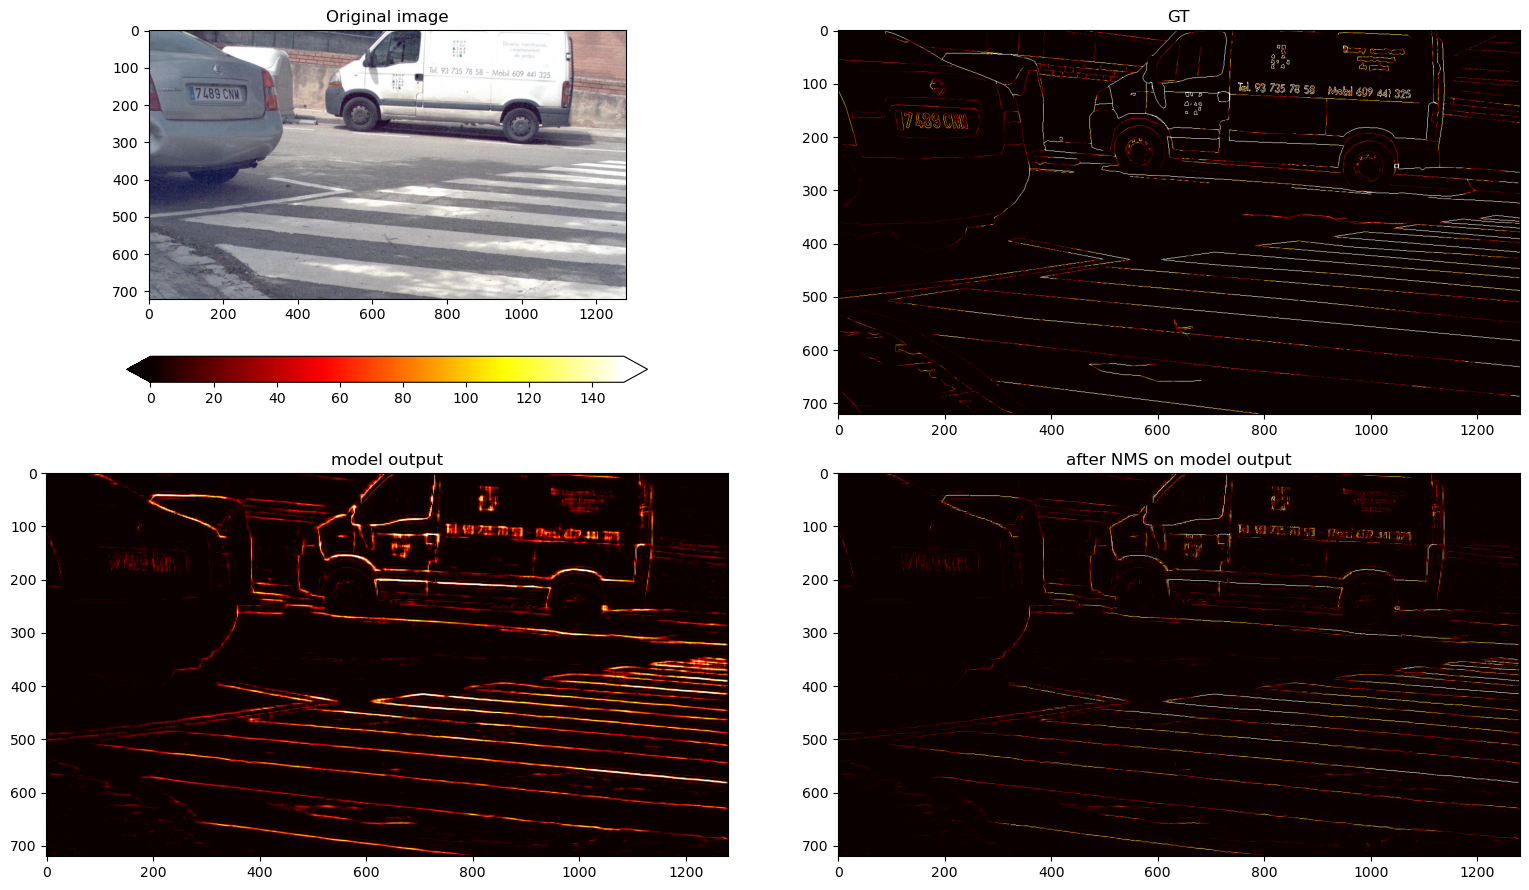

In [25]:
import matplotlib.pyplot as plt
import numpy as np

cmap_type="hot" # plasma, inferno, hot, seismic
vmin, vmax = 0, 150

# display
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

# original image
axes[0,0].imshow(img)
axes[0,0].set_title("Original image")
# axes[0,1].axis('off')  # 不显示坐标轴

im = axes[0,1].imshow(y, cmap=cmap_type, vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axes[0,0], shrink=0.7, location='bottom', extend='both')
axes[0,1].set_title("GT")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[1,0].imshow(yhat, cmap=cmap_type, vmin=vmin, vmax=vmax)
# axes[1,0].imshow(normalisation(yhat, 80), cmap="gray")
axes[1,0].set_title("model output")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[1,1].imshow(edge_map, cmap=cmap_type, vmin=vmin, vmax=vmax)
axes[1,1].set_title("after NMS on model output")
# axes[1,0].axis('off')  # 不显示坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()

In [ ]:
sobel_logging = logging
sobel_before_nms = yhat
sobel_after_nms = edge_map

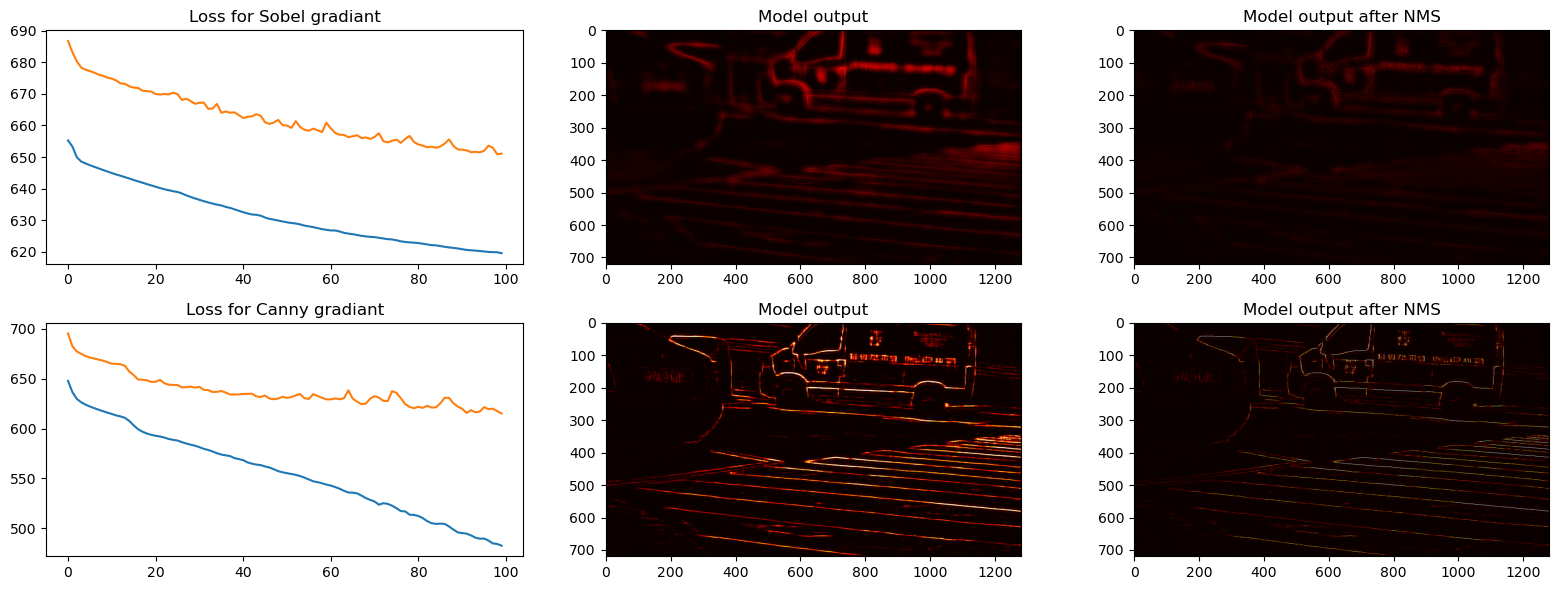

In [28]:
import matplotlib.pyplot as plt
import numpy as np

cmap_type="hot" # plasma, inferno, hot, seismic
vmin, vmax = 0, 150

# display
fig, axes = plt.subplots(2, 3, figsize=(16, 6))

axes[0,0].plot(sobel_logging['train_loss'], label="train loss")
axes[0,0].plot(sobel_logging['val_loss'], label="val loss")
axes[0,0].set_title("Loss for Sobel gradiant")
# axes[0,1].axis('off')  # 不显示坐标轴

axes[0,1].imshow(sobel_before_nms, cmap=cmap_type, vmin=vmin, vmax=vmax)
# fig.colorbar(im, ax=axes[0,0], shrink=0.7, location='bottom', extend='both')
axes[0,1].set_title("Model output")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[0,2].imshow(sobel_after_nms, cmap=cmap_type, vmin=vmin, vmax=vmax)
axes[0,2].set_title("Model output after NMS")
# axes[1,1].axis('off')  # 不显示坐标轴

# original image
axes[1,0].plot(logging['train_loss'], label="train loss")
axes[1,0].plot(logging['val_loss'], label="val loss")
axes[1,0].set_title("Loss for Canny gradiant")
# axes[0,1].axis('off')  # 不显示坐标轴

axes[1,1].imshow(yhat, cmap=cmap_type, vmin=vmin, vmax=vmax)
axes[1,1].set_title("Model output")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[1,2].imshow(edge_map, cmap=cmap_type, vmin=vmin, vmax=vmax)
axes[1,2].set_title("Model output after NMS")
# axes[1,1].axis('off')  # 不显示坐标轴


plt.tight_layout()  # 自动调整子图间距
plt.show()

In [ ]:
# plt.imshow(edge_map, cmap=cmap_type, vmin=vmin, vmax=vmax)
# plt.axis("off")
# plt.savefig(project_root / 'output.png', bbox_inches='tight', pad_inches=0)

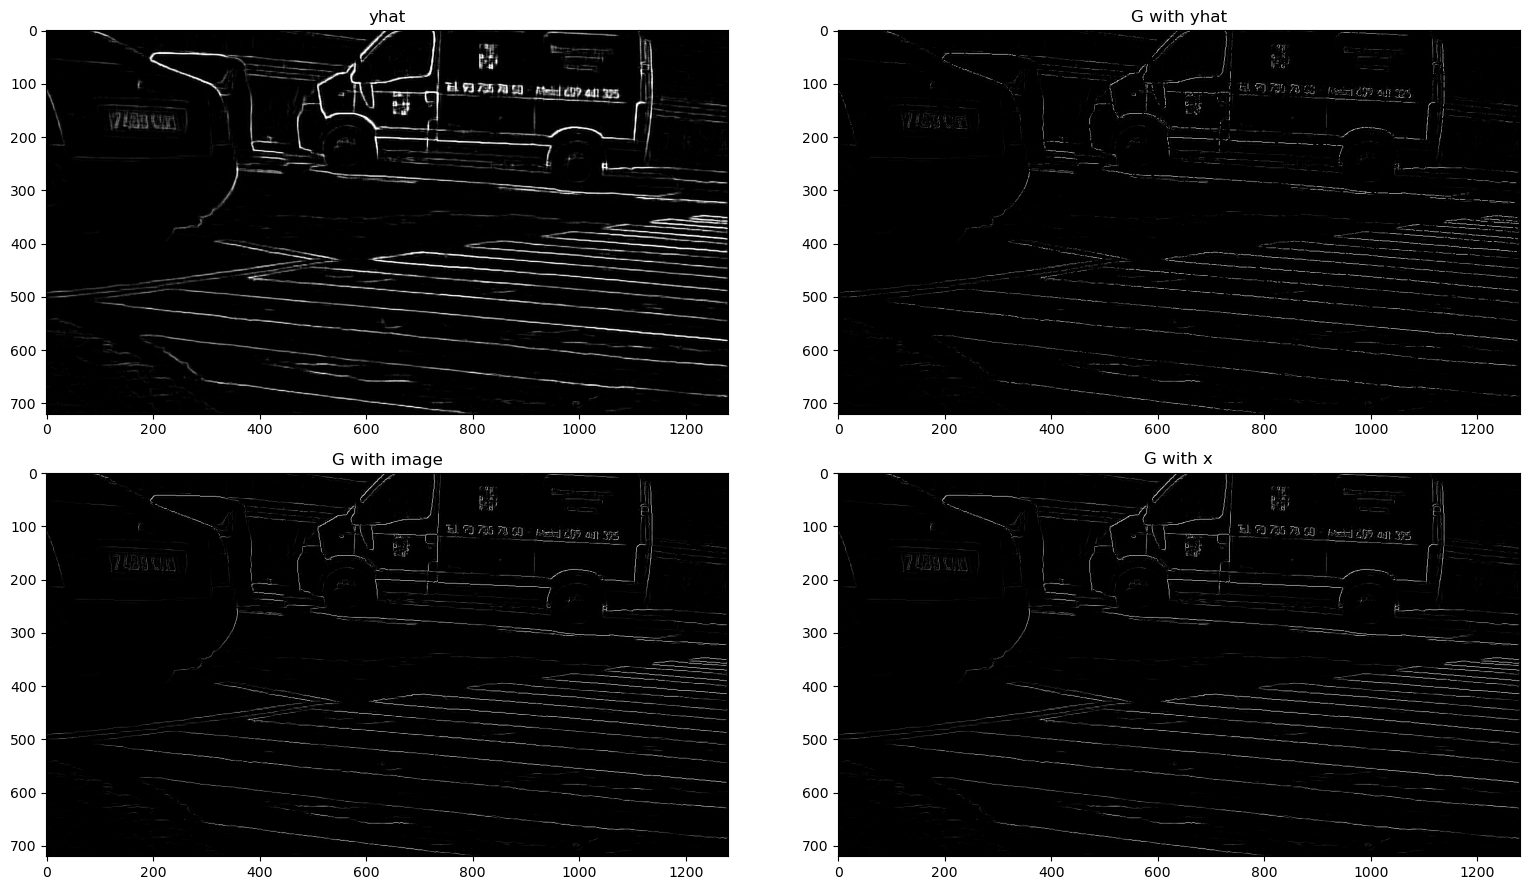

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# display
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

# Loss
axes[0,0].imshow(normalisation(yhat, 80), cmap="gray")
axes[0,0].set_title("yhat")

gx, gy = get_gradient_canny(yhat)
nms_edge = nms_fully_vectorized(yhat, gx, gy)
axes[0,1].imshow(normalisation(nms_edge, 80), cmap="gray")
axes[0,1].set_title("G with yhat")

gx, gy = get_gradient_canny(transforms.ToTensor()(img.convert("L")).squeeze())
nms_edge = nms_fully_vectorized(yhat, gx, gy)
axes[1,0].imshow(normalisation(nms_edge, 80), cmap="gray")
axes[1,0].set_title("G with image")

gx, gy = get_gradient_canny(x.mean(dim=0))
nms_edge = nms_fully_vectorized(yhat, gx, gy)
axes[1,1].imshow(normalisation(nms_edge, 80), cmap="gray")
axes[1,1].set_title("G with x")

plt.tight_layout()  # 自动调整子图间距
plt.show()